In [4]:
# Import necessary libraries
from fastai.vision.all import *
import pandas as pd
import torch
from torch import nn
from torchvision.models import resnet34
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize



In [5]:
!pip install torchcam


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00


In [6]:
! pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu12x

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu12x


In [7]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())




PyTorch Version: 2.5.0+cu121
CUDA Available: False
CUDA Version: 12.1
Number of GPUs: 0


In [13]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 10.4 MB/s eta 0:00:00


In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
data_path = "/content/drive/MyDrive/data/data.yaml"  # Update with the correct path to your YAML file


In [17]:
!yolo task=detect mode=train model=yolo11s.pt data={data_path} epochs=50 plots=True


100% 18.4M/18.4M [00:00<00:00, 122MB/s] 
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/drive/MyDrive/data/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop

In [11]:
!ls runs/detect/train/weights



ls: cannot access 'runs/detect/train/weights': No such file or directory


In [21]:
!ls runs/detect/train8/weights


ls: cannot access 'runs/detect/train8/weights': No such file or directory


In [23]:
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt source=/content/drive/MyDrive/data/test/images conf=0.25 save=True


Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs

image 1/47 /content/drive/MyDrive/data/test/images/frame_100_jpg.rf.93b6f2001ee375f8de2ae5ce170a2c4e.jpg: 128x640 1 Car, 1 Solid White and black, 1 obstacles-Borders, 85.6ms
image 2/47 /content/drive/MyDrive/data/test/images/frame_10_jpg.rf.e17da40663bdb98b54afcdde4ccb5b35.jpg: 128x640 1 Car, 12.4ms
image 3/47 /content/drive/MyDrive/data/test/images/frame_118_jpg.rf.21b6fe8ddfff70b54c1a48cf43468c8f.jpg: 128x640 1 Car, 1 Solid White and black, 11.3ms
image 4/47 /content/drive/MyDrive/data/test/images/frame_125_jpg.rf.1e13fa4adaecf5f7fc0aa488d67151a1.jpg: 128x640 1 Car, 2 Solid White and blacks, 11.6ms
image 5/47 /content/drive/MyDrive/data/test/images/frame_143_jpg.rf.af5ea85df8e72580e29988c6f18cd2be.jpg: 128x640 1 Car, 1 curve, 13.6ms
image 6/47 /content/drive/MyDrive/data/test/images/frame_14_jpg.rf.f4e253a43e59b6e04f0dc

In [24]:
!zip -r prediction_results.zip runs/detect/predict


  adding: runs/detect/predict/ (stored 0%)
  adding: runs/detect/predict/frame_322_jpg.rf.a060d1086ef12eb26d3936f643ca25bb.jpg (deflated 7%)
  adding: runs/detect/predict/frame_205_jpg.rf.f21434a4b1bdd0ed67460436ed424d31.jpg (deflated 6%)
  adding: runs/detect/predict/frame_166_jpg.rf.4c3f98a3e10c96a0cbe41afd0cbfef91.jpg (deflated 6%)
  adding: runs/detect/predict/frame_21_jpg.rf.f70e32b6376915378f0e0353e5891fb3.jpg (deflated 4%)
  adding: runs/detect/predict/frame_229_jpg.rf.42baf7f401bb3f10bce5141c9ca97bff.jpg (deflated 4%)
  adding: runs/detect/predict/frame_425_jpg.rf.3a5ad62c7b33e1931a725436ba538495.jpg (deflated 5%)
  adding: runs/detect/predict/frame_467_jpg.rf.a09b3df2e75b58e82c2535a427279b3a.jpg (deflated 2%)
  adding: runs/detect/predict/frame_10_jpg.rf.e17da40663bdb98b54afcdde4ccb5b35.jpg (deflated 4%)
  adding: runs/detect/predict/frame_308_jpg.rf.a72a861c5b8b2cf880ec9062731c2c4b.jpg (deflated 3%)
  adding: runs/detect/predict/frame_170_jpg.rf.9de2a19c2c784e7bbba9c996bc1c94

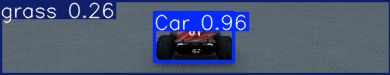

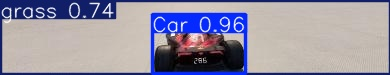

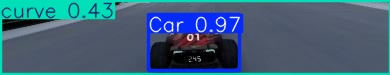

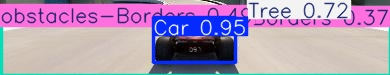

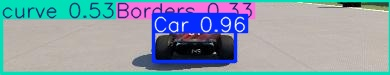

In [32]:
from IPython.display import Image, display
import glob

# Display a few prediction images
for image_path in glob.glob("runs/detect/predict/*.jpg")[:5]:  # Display first 5 images
    display(Image(filename=image_path,))


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from pathlib import Path

In [13]:
# Load the labels CSV
labels_df = pd.read_csv("C:\\Users\\alame\\Desktop\\pro edition\\deep learning\\Supervised\\data\\training ultimate\\controls.csv")

# Path to images
path = Path('C:\\Users\\alame\\Desktop\\pro edition\\deep learning\\Supervised\\data\\training ultimate')


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\alame\\Desktop\\pro edition\\deep learning\\Supervised\\data\\training ultimate\\controls.csv'

# Perform Exploratory Data Analysis (EDA)

In [ ]:
# Cell 1: Display first few rows of the dataset
print("First few rows of the labels dataset:")
print(labels_df.head())

First few rows of the labels dataset:
         frame  left  right  forward  backward
0  frame_0.jpg     0      0        1         0
1  frame_1.jpg     0      0        1         0
2  frame_2.jpg     0      0        1         0
3  frame_3.jpg     0      0        1         0
4  frame_4.jpg     0      0        1         0


In [ ]:
# Cell 2: Summary statistics of the dataset
print("\nSummary statistics of the dataset:")
print(labels_df.describe())




Summary statistics of the dataset:
              left        right      forward     backward
count  1329.000000  1329.000000  1329.000000  1329.000000
mean      0.137698     0.161776     0.854026     0.005267
std       0.344712     0.368384     0.353213     0.072411
min       0.000000     0.000000     0.000000     0.000000
25%       0.000000     0.000000     1.000000     0.000000
50%       0.000000     0.000000     1.000000     0.000000
75%       0.000000     0.000000     1.000000     0.000000
max       1.000000     1.000000     1.000000     1.000000


In [ ]:
# Cell 3: Count of each control action
print("\nCount of each control action:")
control_counts = labels_df[['left', 'right', 'forward', 'backward']].sum()
print(control_counts)




Count of each control action:
left         183
right        215
forward     1135
backward       7
dtype: int64


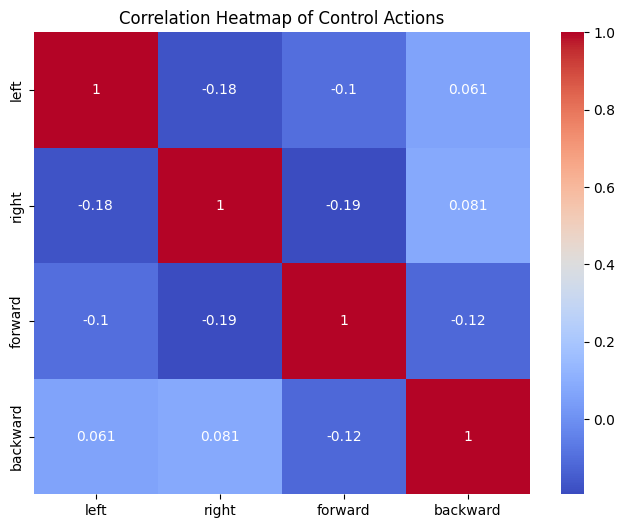

In [ ]:
# Cell 5: Correlation heatmap of control actions
plt.figure(figsize=(8, 6))
sns.heatmap(labels_df[['left', 'right', 'forward', 'backward']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Control Actions')
plt.show()

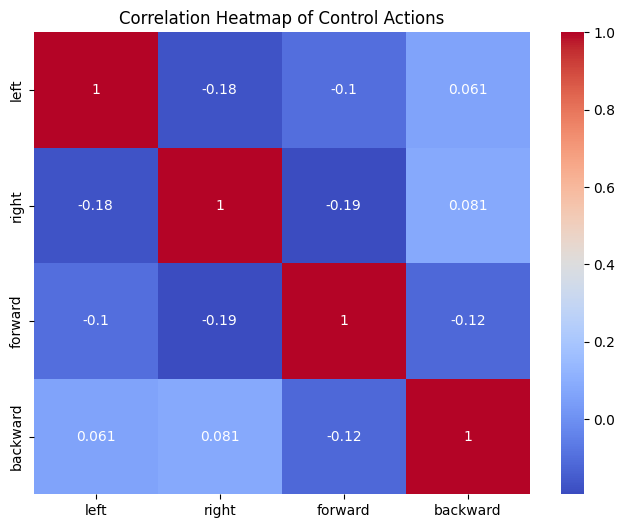

In [ ]:
# Cell 5: Correlation heatmap of control actions
plt.figure(figsize=(8, 6))
sns.heatmap(labels_df[['left', 'right', 'forward', 'backward']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Control Actions')
plt.show()

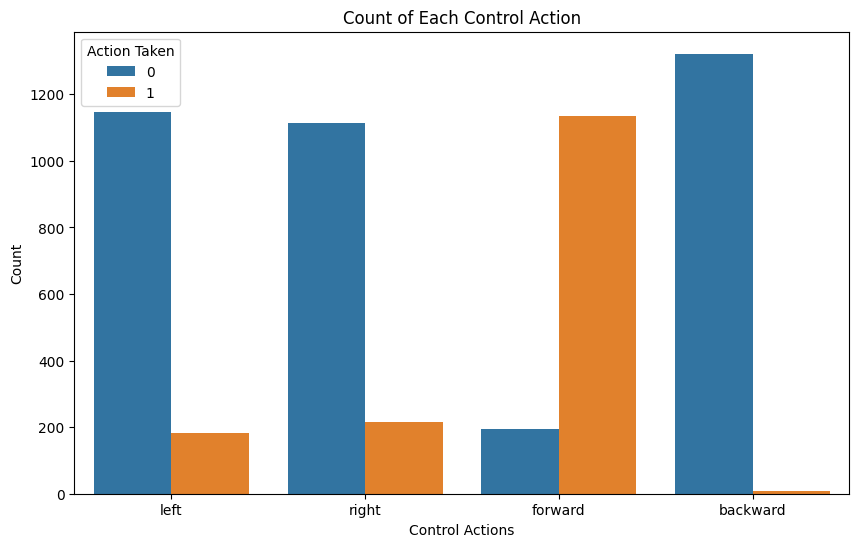

In [ ]:
# Plotting distribution of control actions
plt.figure(figsize=(10, 6))
sns.countplot(data=pd.melt(labels_df, id_vars=['frame'], value_vars=['left', 'right', 'forward', 'backward']),
              x='variable', hue='value')
plt.title('Count of Each Control Action')
plt.xlabel('Control Actions')
plt.ylabel('Count')
plt.legend(title='Action Taken')
plt.show()

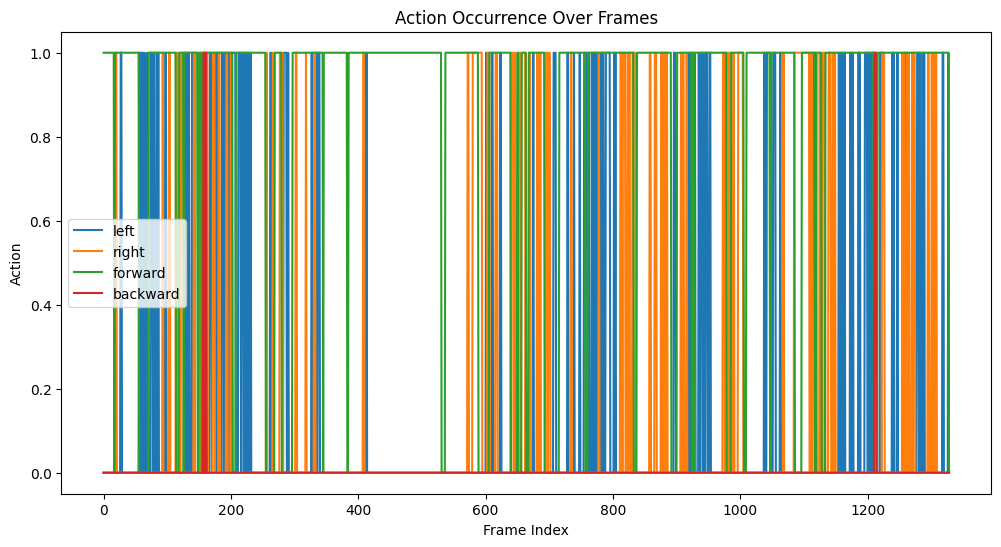

In [ ]:
# Temporal Analysis - Plotting action occurrence over time
plt.figure(figsize=(12, 6))
for action in ['left', 'right', 'forward', 'backward']:
    plt.plot(labels_df.index, labels_df[action], label=action)
plt.xlabel('Frame Index')
plt.ylabel('Action')
plt.title('Action Occurrence Over Frames')
plt.legend()
plt.show()

In [ ]:

# Transition Matrix Calculation
transition_matrix = pd.crosstab(labels_df['forward'].shift(), labels_df['forward'], normalize='index')
print("Transition Matrix:\n", transition_matrix)

Transition Matrix:
 forward         0         1
forward                    
0.0      0.844560  0.155440
1.0      0.027313  0.972687


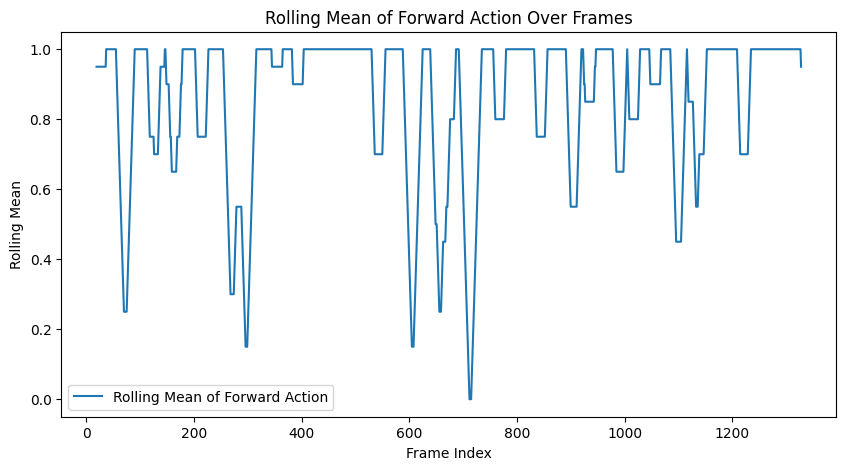

In [ ]:
# Rolling Statistics (e.g., mean of forward action)
rolling_mean = labels_df['forward'].rolling(window=20).mean()
plt.figure(figsize=(10, 5))
plt.plot(rolling_mean, label='Rolling Mean of Forward Action')
plt.title('Rolling Mean of Forward Action Over Frames')
plt.xlabel('Frame Index')
plt.ylabel('Rolling Mean')
plt.legend()
plt.show()

In [47]:
from ultralytics import YOLO

# Load the best-trained model
model = YOLO("runs/detect/train/weights/best.pt")

In [54]:
from fastai.vision.all import *
import pandas as pd
import torch
from torch import nn
from torchvision.models import resnet34
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, random_split

# Load the labels CSV from Google Drive
labels_df = pd.read_csv("/content/drive/MyDrive/data/training ultimate/controls.csv")


# Path to images in Google Drive
path = Path("/content/drive/MyDrive/data/training ultimate")


# Define the `DataBlock`
action_labels = ['left', 'right', 'forward', 'backward']



In [59]:
detected_classes = []
for det in results[0].boxes.data.tolist():
    # Check if the detection has enough elements and the class ID is valid
    if len(det) > 5:
        class_id = int(det[5])
        if class_id < len(classes):  # Check if class ID is within range
            detected_classes.append(classes[class_id])
        else:
            print(f"Warning: Class ID {class_id} is out of range for classes list.")
    else:
        print(f"Incomplete detection data: {det}")

print("Detected classes for the current frame:", detected_classes)


Detected classes for the current frame: ['Car']


In [60]:
from ultralytics import YOLO

# Step 1: Load the best-trained YOLO model
model = YOLO("runs/detect/train/weights/best.pt")

# Step 2: Define classes to detect and initialize yolo_features dictionary
classes = ['Car', 'Solid White and black', 'Tree', 'curve', 'grass', 'obstacles-Borders']

yolo_features = {}

# Step 3: Generate YOLO features by running inference on each frame
for frame_path in labels_df['frame'].unique():
    # Perform inference
    results = model.predict(path / frame_path, save=False)

    # Extract detected classes for the current frame
# Extract detected classes for the current frame, converting det[5] to an integer
# Safely extract detected classes for the current frame, converting det[5] to an integer if available
    detected_classes = [classes[int(det[5])] for det in results[0].boxes.data.tolist() if len(det) > 5]



    # Create a binary feature vector for each class
    yolo_features[frame_path] = torch.tensor(
        [1 if cls in detected_classes else 0 for cls in classes], dtype=torch.float32
    )

# Step 4: Define the `SequenceDatasetWithYOLO`
seq_len = 5
dataset = SequenceDatasetWithYOLO(labels_df, path=path, seq_len=seq_len, transforms=Resize(224), yolo_features=yolo_features)

# Step 5: Split into training and validation datasets
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

# Step 6: Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False)



image 1/1 /content/drive/MyDrive/data/training ultimate/frame_0.jpg: 128x640 1 Car, 24.1ms
Speed: 1.1ms preprocess, 24.1ms inference, 3.6ms postprocess per image at shape (1, 3, 128, 640)

image 1/1 /content/drive/MyDrive/data/training ultimate/frame_1.jpg: 128x640 1 Car, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 128, 640)

image 1/1 /content/drive/MyDrive/data/training ultimate/frame_2.jpg: 128x640 1 Car, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.8ms postprocess per image at shape (1, 3, 128, 640)

image 1/1 /content/drive/MyDrive/data/training ultimate/frame_3.jpg: 128x640 1 Car, 1 Solid White and black, 15.4ms
Speed: 1.0ms preprocess, 15.4ms inference, 1.7ms postprocess per image at shape (1, 3, 128, 640)

image 1/1 /content/drive/MyDrive/data/training ultimate/frame_4.jpg: 128x640 1 Car, 21.7ms
Speed: 1.0ms preprocess, 21.7ms inference, 1.9ms postprocess per image at shape (1, 3, 128, 640)

image 1/1 /content/drive/MyDr

In [2]:
class SequenceDataset(Dataset):
    def __init__(self, df, path, seq_len=5, transforms=None, yolo_detections=None, classes=['Car', 'curve', 'obstacle', 'grass']):
        self.df = df
        self.path = path
        self.seq_len = seq_len
        self.transforms = transforms
        self.yolo_detections = yolo_detections  # Dictionary of YOLO detections for each frame
        self.classes = classes  # List of all possible object classes

    def __len__(self):
        return len(self.df) - self.seq_len + 1

    def _get_yolo_features(self, frame_name):
        # Convert detected objects into a binary vector based on `self.classes`
        detections = self.yolo_detections.get(frame_name, [])
        feature_vector = torch.tensor([1 if cls in detections else 0 for cls in self.classes], dtype=torch.float32)
        return feature_vector

    def __getitem__(self, idx):
        frames, labels, yolo_features = [], [], []
        for i in range(self.seq_len):
            row = self.df.iloc[idx + i]
            frame_name = row['frame']

            # Load and transform the image
            image = PILImage.create(self.path / frame_name)
            if self.transforms:
                image = self.transforms(image)
            frames.append(ToTensor()(image).float())

            # Get label for the last frame in the sequence
            labels.append(torch.tensor([row['left'], row['right'], row['forward'], row['backward']], dtype=torch.float))

            # Add YOLO features
            yolo_features.append(self._get_yolo_features(frame_name))

        # Stack frames and YOLO features into tensors
        frames = torch.stack(frames).to(torch_device)
        yolo_features = torch.stack(yolo_features).to(torch_device)
        labels = labels[-1].to(torch_device)  # Only the last frame's label

        return (frames, yolo_features), labels



NameError: name 'Dataset' is not defined

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class SequenceDatasetWithYOLO(Dataset):
    def __init__(self, df, path, seq_len=5, transforms=None, yolo_features=None):
        self.df = df
        self.path = path
        self.seq_len = seq_len
        self.transforms = transforms
        self.yolo_features = yolo_features  # Dictionary with YOLO features for each frame

    def __len__(self):
        return len(self.df) - self.seq_len + 1

    def __getitem__(self, idx):
        frames, labels, yolo_features_list = [], [], []
        for i in range(self.seq_len):
            row = self.df.iloc[idx + i]
            image = PILImage.create(self.path / row['frame'])
            if self.transforms:
                image = self.transforms(image)
            frames.append(ToTensor()(image).float())
            labels.append(torch.tensor([row['left'], row['right'], row['forward'], row['backward']], dtype=torch.float))

            # Fetch YOLO features for the frame
            yolo_features_list.append(self.yolo_features[row['frame']])

        frames = torch.stack(frames).to(torch_device)
        yolo_features = torch.stack(yolo_features_list).to(torch_device)  # Shape (seq_len, yolo_feature_dim)
        labels = labels[-1].to(torch_device)
        return (frames, yolo_features), labels




# Prepare DataLoader as before, with `SequenceDatasetWithYOLO`
# Assuming `yolo_features` is a dictionary with YOLO features for each frame.
seq_len = 5
dataset = SequenceDatasetWithYOLO(labels_df, path=path, seq_len=seq_len, transforms=Resize(224), yolo_features=yolo_features)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# Initialize model and train with custom loss function as in your previous setup.
model = CNN_LSTM_YOLO(cnn_base=resnet_base, lstm_hidden_dim=128, n_classes=4, yolo_feature_dim=yolo_feature_dim).to(torch_device)


NameError: name 'labels_df' is not defined

In [64]:
# Check if CUDA is available

if torch.cuda.is_available():
    print("CUDA is available! Using GPU.")
    torch_device = torch.device("cuda")
else:
    print("CUDA is not available. Using CPU.")
    torch_device = torch.device("cpu")

CUDA is available! Using GPU.


In [65]:
import torch

# Define the device
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class weights based on observed class frequencies
class_weights = torch.tensor([3.0, 3.0, 1.0, 5.0]).to(torch_device)  # Adjust weights as per class imbalance

# Weighted BCEWithLogitsLoss for multi-label regression
loss_func = BCEWithLogitsLoss(pos_weight=class_weights)



In [66]:
# Custom accuracy metric for multi-label classification
def custom_accuracy_multi(preds, targs, thresh=0.5):
    preds = preds.sigmoid()
    return ((preds > thresh) == targs.bool()).float().mean()

# Wrap the model in a Learner
learn = Learner(
    dls=DataLoaders(train_dataloader, valid_dataloader),
    model=model,
    loss_func=loss_func,
    metrics=custom_accuracy_multi,
    cbs=[SaveModelCallback(monitor='custom_accuracy_multi')]
)

# Train the model
learn.fine_tune(10, base_lr=1e-3)

# Save the model
learn.export("trackmania_cnn_lstm_model.pkl")

IndexError: list index out of range

In [ ]:
# Find the optimal learning rate
learn.lr_find()

In [ ]:
# Get validation set predictions
preds, targs = learn.get_preds(dl=dls.valid)

# Calculate the accuracy or other metrics for validation predictions
accuracy = accuracy_multi(preds, targs, thresh=0.5).item()
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.5019


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

# Convert predictions and targets to binary (0 or 1) for each label
preds_binary = (preds > 0.5).int()
targs_binary = targs.int()

# Calculate a confusion matrix for each label
confusion_matrices = multilabel_confusion_matrix(targs_binary, preds_binary)

for i, label in enumerate(action_labels):
    print(f"Confusion Matrix for {label}:\n{confusion_matrices[i]}\n")


Confusion Matrix for left:
[[150  89]
 [ 13  13]]

Confusion Matrix for right:
[[192  22]
 [ 45   6]]

Confusion Matrix for forward:
[[ 10  18]
 [ 77 160]]

Confusion Matrix for backward:
[[251  13]
 [  0   1]]



Predicted: ['left'], Actual: ['forward']
Predicted: ['right', 'backward'], Actual: ['forward']
Predicted: ['left'], Actual: ['forward']
Predicted: [], Actual: ['forward']
Predicted: ['right', 'forward', 'backward'], Actual: ['forward']


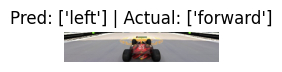

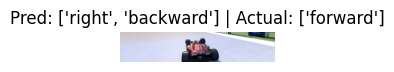

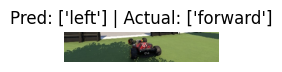

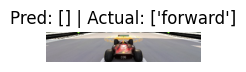

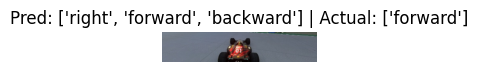

In [ ]:
# Ensure binary predictions and targets
preds_binary = (preds > 0.5).int()
targs_binary = targs.int()

# Find indices of misclassified images
misclassified_idxs = (preds_binary != targs_binary).any(dim=1).nonzero(as_tuple=True)[0]  # Get flat integer indices

# Display a few misclassified examples
for idx in misclassified_idxs[:5]:  # Show the first 5 misclassifications
    img, label = dls.valid_ds[int(idx)]  # Convert idx to an integer
    pred_labels = [action_labels[i] for i, p in enumerate(preds_binary[idx]) if p == 1]
    actual_labels = [action_labels[i] for i, t in enumerate(targs_binary[idx]) if t == 1]
    print(f"Predicted: {pred_labels}, Actual: {actual_labels}")
    img.show(title=f"Pred: {pred_labels} | Actual: {actual_labels}")


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score for each action label
for i, label in enumerate(action_labels):
    precision = precision_score(targs_binary[:, i], preds_binary[:, i])
    recall = recall_score(targs_binary[:, i], preds_binary[:, i])
    f1 = f1_score(targs_binary[:, i], preds_binary[:, i])
    print(f"{label}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")


left: Precision = 0.1275, Recall = 0.5000, F1 = 0.2031
right: Precision = 0.2143, Recall = 0.1176, F1 = 0.1519
forward: Precision = 0.8989, Recall = 0.6751, F1 = 0.7711
backward: Precision = 0.0714, Recall = 1.0000, F1 = 0.1333


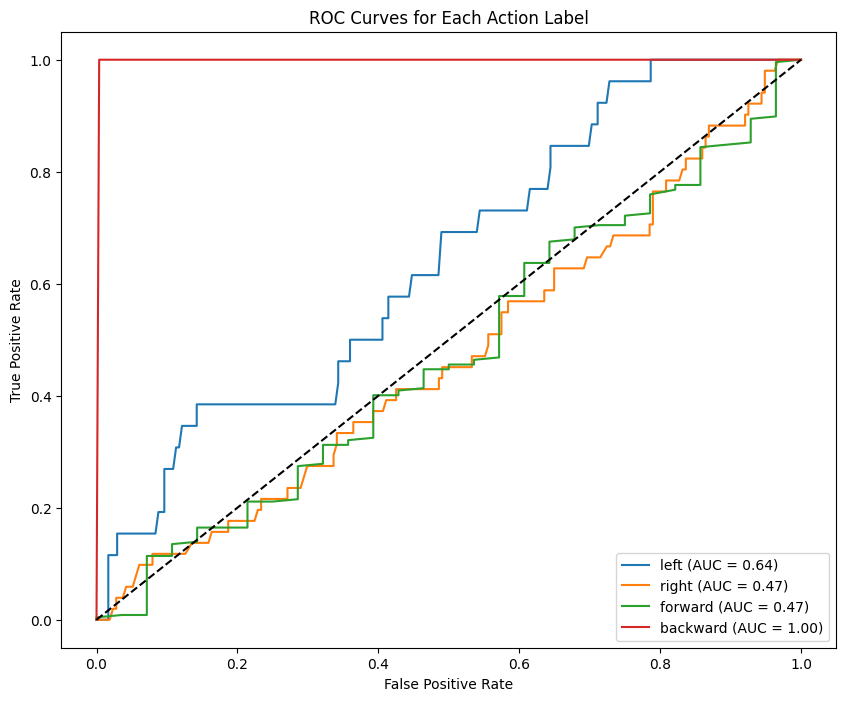

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for i, label in enumerate(action_labels):
    fpr, tpr, _ = roc_curve(targs_binary[:, i], preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Action Label")
plt.legend(loc="lower right")
plt.show()


In [ ]:
print(learn.model)


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Predicted: ['left'] | Actual: ['forward']


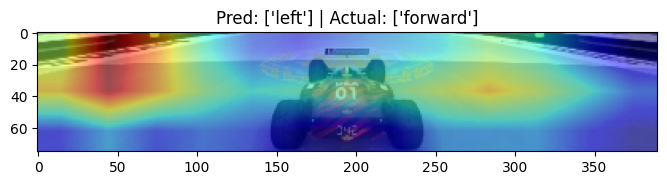

Predicted: ['right', 'backward'] | Actual: ['forward']


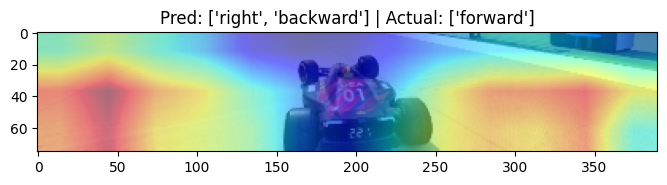

Predicted: ['left'] | Actual: ['forward']


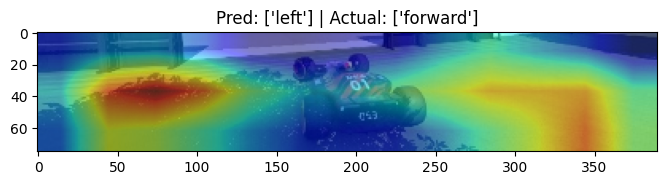

In [ ]:
from torchcam.methods import SmoothGradCAMpp  # SmoothGradCAM++ for more refined heatmaps
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import torch
from fastai.vision.augment import ToTensor
import torchvision.transforms.functional as TF

# Initialize the Grad-CAM object for your learner's model, targeting the last convolutional layer
cam_extractor = SmoothGradCAMpp(learn.model, target_layer='0.7')  # Adjusted target layer

# Display Grad-CAM for a few misclassified examples
for idx in misclassified_idxs[:3]:  # First 3 misclassifications
    img, label = dls.valid_ds[int(idx)]
    actual_labels = [action_labels[i] for i, t in enumerate(targs_binary[idx]) if t == 1]
    pred_labels = [action_labels[i] for i, p in enumerate(preds_binary[idx]) if p == 1]
    print(f"Predicted: {pred_labels} | Actual: {actual_labels}")

    # Convert FastAI image to tensor, change to float, and normalize to [0, 1]
    img_tensor = ToTensor()(img).float().div(255)  # Convert to FloatTensor and scale to [0, 1]
    img_tensor = img_tensor.unsqueeze(0).to(learn.dls.device)  # Add batch dimension and move to device

    # Forward pass to get the output predictions
    output = learn.model(img_tensor)

    # Get the Grad-CAM heatmap for the highest predicted label
    cam = cam_extractor(output.squeeze(0).argmax().item(), output)

    # Resize the CAM heatmap to the image dimensions
    cam_resized = TF.resize(to_pil_image(cam[0].cpu().detach()), img_tensor.shape[-2:])  # Resize to match image size

    # Display the Grad-CAM on top of the original image
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(to_pil_image(img_tensor.squeeze(0).cpu()))  # Display the original image
    ax.imshow(cam_resized, cmap='jet', alpha=0.5)  # Overlay resized heatmap
    ax.set_title(f"Pred: {pred_labels} | Actual: {actual_labels}")
    plt.show()


SuggestedLRs(valley=0.004365158267319202)

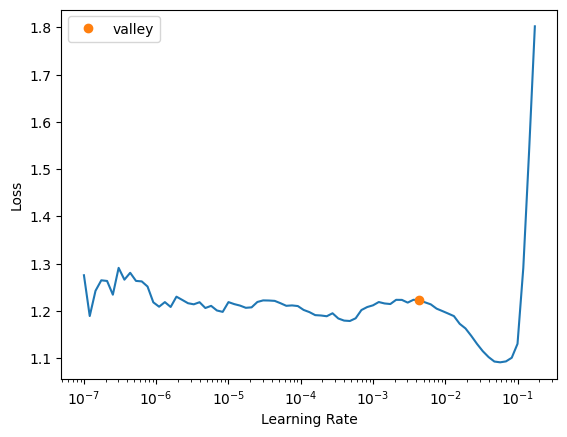

In [ ]:
# Step 8: Find the optimal learning rate
learn.lr_find()
# Use the valley learning rate from the plot

In [ ]:
print(f"Input tensor shape: {learn.dls.train.one_batch()[0].shape}")
print(f"Target tensor shape: {learn.dls.train.one_batch()[1].shape}")




Input tensor shape: torch.Size([64, 3, 224, 224])
Target tensor shape: torch.Size([64, 4])


C:\Users\alame\AppData\Roaming\Python\Python312\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=devic

SuggestedLRs(valley=0.0020892962347716093)

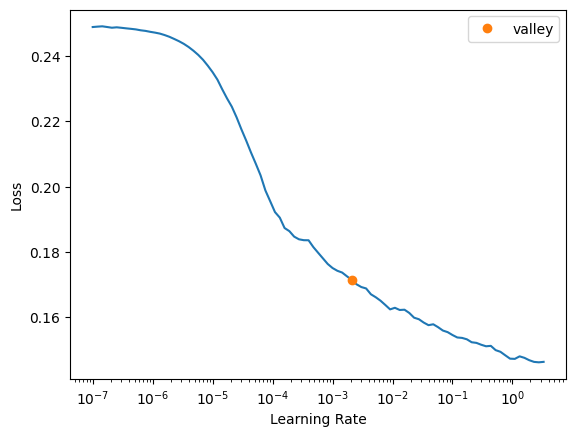

In [ ]:
# Step 8: Find the optimal learning rate
learn.lr_find()
# Use the valley learning rate from the plot

In [ ]:
from fastai.vision.all import *
import pandas as pd
import torch
from torch import nn
from torchvision.models import resnet18

# Load the labels CSV
labels_df = pd.read_csv("C:\\Users\\alame\\Desktop\\pro edition\\deep learning\\AutoMania\\Supervised\\data\\combined_train\\combined_controls.csv")

# Path to images
path = Path('C:\\Users\\alame\\Desktop\\pro edition\\deep learning\\AutoMania\\Supervised\\data\\combined_train')

def crop_car(img):
    width, height = img.size
    left = (width - 200) / 2  # Crop 200 pixels wide centered horizontally
    right = (width + 200) / 2
    top = (height - 50) / 2  # Crop 50 pixels tall centered vertically
    bottom = (height + 50) / 2
    return img.crop((left, top, right, bottom))  # Crop the image

# Define a function to get the control inputs (left, right, forward, backward)
def get_y(row):
    labels = []
    if row['left'] == 1: labels.append('left')
    if row['right'] == 1: labels.append('right')
    if row['forward'] == 1: labels.append('forward')
    if row['backward'] == 1: labels.append('backward')
    return labels

def get_x(row):
    img_path = path / row['frame']
    img = PILImage.create(img_path)
    return crop_car(img)  # Crop the image to focus on the car

# DataBlock for regression task
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),  # Images as input, binary labels as output
    get_x=get_x,  # Get image path
    get_y=get_y,  # Get control inputs as a tensor
    splitter=RandomSplitter(valid_pct=0.2),  # Split train/validation
    item_tfms=Resize((395, 222)),  # Resize images to the required dimensions
    batch_tfms=aug_transforms(  # Apply realistic augmentations during training
        flip_vert=False,          # Do not flip vertically
        max_rotate=2.0,           # Allow small rotations (up to 5 degrees)
        max_zoom=1.02,            # Slight zoom in/out (5% zoom)
        max_warp=0.1,             # Apply small perspective warps
        p_affine=0.75,            # Probability of applying affine transforms (rotation/zoom)
        p_lighting=0.3           # Probability of applying lighting transformations (brightness/contrast)

    )

)

# Create DataLoaders
dls = dblock.dataloaders(labels_df, bs=16)

# Define the CNN + LSTM model
class ResNetLSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pretrained ResNet50 model
        self.resnet = resnet18(weights='IMAGENET1K_V1')
        # Remove the last fully connected layer of ResNet50
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        # LSTM to capture temporal dependencies
        self.lstm = nn.LSTM(input_size=2048, hidden_size=1024, num_layers=3, batch_first=True, dropout=0.5)
        # Fully connected layer for final prediction
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout added here
            nn.Linear(512, 4)  # Predicting left, right, forward, backward
        )

    def forward(self, x):
        # Expecting input of shape (batch_size, C, H, W)
        batch_size = x.size(0)

        # Extract features from the image using ResNet50
        frame_features = self.resnet(x)  # Shape: (batch_size, 2048, 1, 1)
        frame_features = frame_features.view(batch_size, 1, -1)  # Shape: (batch_size, 1, 2048)

        # Pass through LSTM
        lstm_out, _ = self.lstm(frame_features)  # Shape: (batch_size, 1, 512)

        # Take the output of the LSTM cell
        output = lstm_out[:, -1, :]  # Shape: (batch_size, 512)

        # Fully connected layer to get final prediction
        output = self.fc(output)  # Shape: (batch_size, 4)

        return output

if __name__ == "__main__":
# Instantiate the model
    model = ResNetLSTMModel()

# Use BCEWithLogitsLoss for multi-label binary classification
    loss_func = nn.BCEWithLogitsLoss()

# Add L2 Regularization (weight decay) for better generalization

    pos_weight = torch.tensor([2.0, 2.0, 0.5, 3.0])  # Adjust based on the imbalance
    loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy_multi], wd=5e-4)

    # Training with frozen ResNet layers
    print("Training the model with frozen ResNet layers")
    learn.freeze()
    learn.fit_one_cycle(7, slice(1e-5, 1e-3))  # Training with frozen layers

    # Unfreeze the model for fine-tuning
    print("Fine-tuning the model with all layers")
    learn.unfreeze()
    learn.fit_one_cycle(5, slice(1e-5, 1e-4))  # Fine-tuning with all layers unfrozen

    # Evaluate the model
    print("Evaluating the model on validation set")
    learn.validate()

    # Save the trained model
    learn.export('trackmania_car_detection_model.pkl')
